In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Embeddings

In [2]:
food_embds = np.load('data/food_embds.npy')
food_names = [x[:-5] for x in np.load('data/food_names.npy',allow_pickle=True)]

In [3]:
print(food_embds.shape)
print(len(food_names))

(36073, 50)
36072


## Optional

In [31]:
# find senza food idx
df_food_items = pd.read_csv('data/senza_app_fooditems.csv', low_memory=False)

In [42]:
m = df_food_items['food_name'].isin(food_names)
g = df_food_items[m][['food_name','nx_food_id']].groupby(by='food_name').nunique().sort_values(by='nx_food_id',ascending=False)
g

,food_name,nx_food_id
food_name,,
Coffee,1,1776
Chicken Salad,1,1302
Salad,1,1232
Extra Virgin Olive Oil,1,1174
Tuna Salad,1,1073
...,...,...
"Homemade Chili, Bowl",1,1
Homemade Chicken Stock,1,1
Homemade Bread - 1 thin slice,1,1


In [48]:
# test
m = df_food_items['food_name']=='Coffee'
df_food_items.loc[m,'nx_food_id'].values

array(['d3ea445462acee818513deea', 'senza-588446-1628698173', 'senza-588280-1628641273', ..., '555b5215d962a16c17fee2e0', '552bc3d90ab300ad64cc066f', 'YA1tKr3e'], dtype=object)

In [50]:
#mapping from name to array of `nx_food_id`
name2idxs = {x:df_food_items.loc[df_food_items['food_name']==x,'nx_food_id'].values for x in food_names}

KeyboardInterrupt: 

## Set up Annoy Index for food embeddings

In [6]:
from annoy import AnnoyIndex

In [ ]:
dims = food_embds.shape[1]
t = AnnoyIndex(dims,metric='angular')  # Length of item vector that will be indexed
for i,row in enumerate(food_embds):
    t.add_item(i, row)
t.build(2000) # 10 trees
t.save('ann_index/foods.ann')

In [22]:
# Load NN index

In [7]:
dims = food_embds.shape[1]
u = AnnoyIndex(dims, 'angular')
u.load('ann_index/foods.ann') # super fast, will just mmap the file

True

In [8]:
food_names[2]

'Avocado'

In [11]:
item = 30721
num_nn = 20
res = u.get_nns_by_item(item, num_nn) # will find the 100 nearest neighbors
print(f'The {num_nn} closest items to {food_names[item]} are:\n')
for i in res:
    print(food_names[i])
print(res)

The 20 closest items to Creamy Garlic Parmesan Brussels Sprouts are:

Creamy Garlic Parmesan Brussels Sprouts
Half Pound Beef And Cheddar, No Bun
Portabella Mushrooms (Organic)
Garlic Spread & Seasoning
Double  Steak Burger Lettuce Wrapped 
Amber Color Maple Syrup
Apples, raw, gala, with skin
Queso
Golden Flaxseed Meal
Organic Roasted Teriyaki Seaweed Snack
Fudge Caramel
Avocado
Keto Popsicles
Chocolate Chip Cookie Dough Fat Bombs 
S'mores Protein Meal Replacement Bar
Fully Cooked Turkey Bacon
Vodka Soda, Pineapple
Premium Seafood Mix
Chop Steak (Where Available)
Super Collagen Dietary Supplement, Powder
[30721, 35479, 27599, 33529, 4582, 18748, 463, 334, 12774, 33136, 31478, 2, 35195, 18834, 11518, 31469, 29174, 32899, 34430, 8972]


## UI elements

In [63]:
import ipywidgets as ipw

In [64]:
ipw.Dropdown(list=[(name,i) for i,name in enumerate(food_names)])

Dropdown(options=(), value=None)

# Testing Annoy Index

In [ ]:
import annoy

In [4]:
%%time
dims = 40
t = AnnoyIndex(dims, 'angular')  # Length of item vector that will be indexed
for i in range(300000):
    v = [random.gauss(0, 1) for z in range(dims)] # inefficient way of generating random array but okay
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

CPU times: user 14.4 s, sys: 769 ms, total: 15.2 s
Wall time: 11.5 s


In [5]:
%%timeit
dims = 40
u = AnnoyIndex(dims, 'angular')
u.load('test.ann') # super fast, will just mmap the file
res = u.get_nns_by_item(0, 100) # will find the 100 nearest neighbors

1.92 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Total prediction Time
Model Prediction: 141ms
Annoy Recovery: 2.04ms
### Space Cost
Model: 50MB
Annoy Index: 1GB

# Let's build an app workflow
0) app launch - load index  
1) somehow check payment token  
2) app gets a json  
3) app unpacks the json and calls nearest neighbor function  
4) app returns nearest items  

In [216]:
dims = 10
t = annoy.AnnoyIndex(dims, 'angular')  # Length of item vector that will be indexed
for i in range(30000):
    v = [random.gauss(0, 1) for z in range(dims)] # inefficient way of generating random array but okay
    t.add_item(i, v)

t.build(1) # 10 trees
t.save('test.ann')

True

In [217]:
class nnApp():
    def __init__(self,index_file,dims,metric='angular'):
        self.dims=dims
        self.nn_ind=annoy.AnnoyIndex(self.dims, metric)
        self.nn_ind.load(index_file)
    
    def handle_request(self,req_dict):
        "currently handles only request of k NN, close to ind"
        res=[],[]
        if req_dict['ind'] is not None:
            temp=self.nn_ind.get_nns_by_item(req_dict['ind'], 
                                            req_dict['k']+1,
                                            include_distances=True)
            #adjustment because it returns itself as closest item
            res=temp[0][1:],temp[1][1:]
        if req_dict['vec'] is not None:
            if self.check_vec_dim(vec):
                res=self.nn_ind.get_nns_by_vector(req_dict['vec'], 
                                                  req_dict['k'],
                                                  include_distances=True)
        return {'nns':res}
    
    def check_vec_dim(self,vec):
        return True if len(vec) == self.dims else False
        


In [218]:
app = nnApp(index_file='test.ann',dims=dims)

In [219]:
num_nn =100
vec = app.nn_ind.get_item_vector(42)
req_dict = {'vec':None,'k':num_nn,'ind':42}
by_ind = app.handle_request(req_dict)['nns']
req_dict = {'vec':vec,'k':num_nn,'ind':None}
by_vec = app.handle_request(req_dict)['nns']

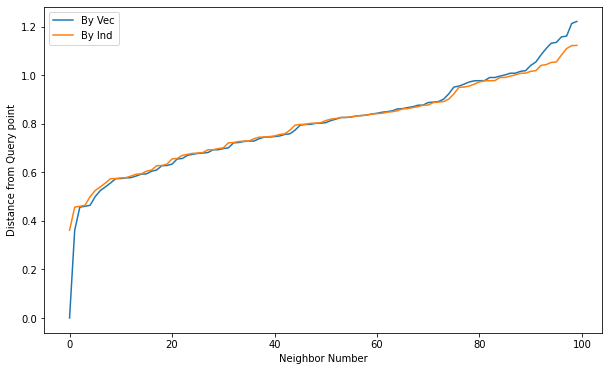

In [220]:
f,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(range(num_nn),by_vec[1],label='By Vec')
ax.plot(range(num_nn),by_ind[1],label='By Ind')
ax.set_xlabel('Neighbor Number')
ax.set_ylabel('Distance from Query point')
ax.legend()

`By vector` and `by item` yield different results. The more trees, the more different the results.

In [221]:
len([x for x in by_vec[0] if x in by_ind[0]])

93

Little overlap in returned items, probably due to the fact that random vectors have very similar angles?   
Yes->Lower dimensionality gets almost identical results (dims=3 vs dims=40)